## Kaggle Competition

### TalkingData AdTracking Fraud Detection Challenge

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/data

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

### Goal:
For this competition, your objective is to predict whether a user will download an app after clicking a mobile app advertisement.

File descriptions
train.csv - the training set
train_sample.csv - 100,000 randomly-selected rows of training data, to inspect data before downloading full set
test.csv - the test set
sampleSubmission.csv - a sample submission file in the correct format
UPDATE: test_supplement.csv - This is a larger test set that was unintentionally released at the start of the competition. It is not necessary to use this data, but it is permitted to do so. The official test data is a subset of this data.
Data fields
Each row of the training data contains a click record, with the following features.



## Evaluation: 

#### Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

#### Submission File
- For each click_id in the test set, you must predict a probability for the target is_attributed variable. The file should contain a header and have the following format:

click_id,is_attributed <br>
    1,0.003 <br>
    2,0.001 <br>
    3,0.000 <br>
    etc.

### My Notes 
1. Data is too large to sync up with github. 
    - 7.3 Gb 
    - 184 million clicks over 4 days

## Load my functions

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sn

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn import metrics
import fastai.imports as fastimp
import fastai.structured as faststruct
from fastai.imports import *
from fastai.structured import * 

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
def display_all(df):
    '''this prevents truncating the cols or rows'''
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
# from kaggle site.

import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))


## Import Data

### Main data file Import:

In [5]:
#import data into smaller int8 to save space. 
dtypes = {"ip":"int32", "app":"int32", "device":"int16", "os": "int16", "channel": "int16", "click_time": "object", \
 "attributed_time": "object", "is_attributed": "int8"}

In [280]:
# %reset_selective -f "^df_raw$"

In [10]:
# %who_ls

In [7]:
# import the datset
# I will split the training data into train and test and perform k-folds on the training. 
# then will use the test.csv as the final validation

train_data_loc = "~/mw_portfolio/notebooks-projects-code-notes/dataset/Ad_tracking_fraud_detection/mnt/ssd/kaggle-talkingdata2/competition_files/train.csv"
%time df_raw = pd.read_csv(f'{train_data_loc}', low_memory=False, dtype=dtypes)

CPU times: user 1min 52s, sys: 25.7 s, total: 2min 18s
Wall time: 2min 55s


In [8]:
%time print(len(set(df_raw.ip)))
%time print(len(set(df_raw.os)))
print(len(set(df_raw.app)))
print(len(set(df_raw.device)))
print(len(set(df_raw.channel)))
print(len(df_raw))

277396
CPU times: user 21.1 s, sys: 3.47 s, total: 24.5 s
Wall time: 24.5 s
800
CPU times: user 4.05 s, sys: 642 ms, total: 4.69 s
Wall time: 4.67 s
706
3475
202
184903890


In [123]:
# normally i would want to save the file off to a feather format, 
# because it is much faster than importing each time to a DF. 
## saving to disk gave an error disable for now. 
# known issue for very large datasets. 
# os.makedirs('tmp', exist_ok=True)
# %time df_raw.to_feather('tmp/ad_track_fraud_raw')

In [11]:
df_raw.head(1000)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0
5,18787,3,1,16,379,2017-11-06 14:36:26,NaN,0
6,103022,3,1,23,379,2017-11-06 14:37:44,NaN,0
7,114221,3,1,19,379,2017-11-06 14:37:59,NaN,0
8,165970,3,1,13,379,2017-11-06 14:38:10,NaN,0
9,74544,64,1,22,459,2017-11-06 14:38:23,NaN,0


In [8]:
# a cool method to transpose the cols and rows for each scrolling
display_all(df_raw.tail().T)

,184903885,184903886,184903887,184903888,184903889
ip,-9760,-18642,-7554,-7322,-24587
app,12,3,1,12,11
device,1,1,1,1,1
os,10,19,13,37,19
channel,84,-45,18,3,-119
click_time,2017-11-09 16:00:00,2017-11-09 16:00:00,2017-11-09 16:00:00,2017-11-09 16:00:00,2017-11-09 16:00:00
attributed_time,NaN,NaN,NaN,NaN,NaN
is_attributed,0,0,0,0,0


### what does the test data look like?
- opened the file in linux tail and head to view basic info
- start date 11-10-2017
- how many records 18790468
- over an 11 hour time period from 04:00 to 15:00

### Subset main data file time series date slices:
- let's take a subset of data for working through the process.
- once we have selected our features and establisthed the process, 
- we will rerun all of the steps for the full dataset.

#### Take a subset of the most recent data instead of a random sample of all of the data. 
- Also take a small enough sample that model fit and feature engineering moves quickly. 

In [131]:
# sort by click time. 
%time df_raw = df_raw.sort_values('click_time')

CPU times: user 2min 37s, sys: 7.77 s, total: 2min 45s
Wall time: 2min 45s


### subset the 1st day of data, and try fit and predict off that model
- what happens as the data gets older annd older from the original fit.??
    - As the days pass how will date features impact the predictions? 
    - for example will more and more clicks fall into the bucket of fraud because the split could say anything greater than x seconds or > than x datetime could fall into fraud so more and more new clicks predicted will be fraud. 
    - this means the fit model could become stale and no longer predict properly. 
    - 
    - 
    
    - to test this we will create a validation set that is first the next day, and then the last day to see how the roc-auc score changes. 


In [152]:
# take the first day of data and copy to new df
%time df_raw_subset_big = df_raw[:55000100].copy()

CPU times: user 468 ms, sys: 645 ms, total: 1.11 s
Wall time: 1.11 s


In [153]:
len(df_raw_subset_big)

55000100

In [12]:
# take the last n rows. 
%time df_raw_subset = df_raw[:2000000:].copy()
df_raw_subset.reset_index(drop=True, inplace=True)
%time add_datepart(df_raw_subset, 'click_time', time=True)
df_raw_subset.head()

CPU times: user 21.7 ms, sys: 27.7 ms, total: 49.4 ms
Wall time: 48.9 ms
CPU times: user 1.74 s, sys: 356 ms, total: 2.1 s
Wall time: 2.1 s


,ip,app,device,os,channel,attributed_time,is_attributed,click_timeYear,click_timeMonth,click_timeWeek,...,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,click_timeHour,click_timeMinute,click_timeSecond,click_timeElapsed
0,83230,3,1,13,379,NaN,0,2017,11,45,...,False,False,False,False,False,False,14,32,21,1509978741
1,17357,3,1,19,379,NaN,0,2017,11,45,...,False,False,False,False,False,False,14,33,34,1509978814
2,35810,3,1,13,379,NaN,0,2017,11,45,...,False,False,False,False,False,False,14,34,12,1509978852
3,45745,14,1,13,478,NaN,0,2017,11,45,...,False,False,False,False,False,False,14,34,52,1509978892
4,161007,3,1,13,379,NaN,0,2017,11,45,...,False,False,False,False,False,False,14,35,8,1509978908


In [76]:
#check for null values
# print(df_raw_subset.isnull().sum())
df_raw_subset.fillna(value=0, inplace=True)

In [130]:
# df_raw_subset.loc[df_raw_subset['attributed_time']==1, 'attributed_time']= np.nan

# #save off to a feather format for faster access later
# %time df_raw_subset.to_feather('tmp/ad_track_fraud_raw_subset_last_500k')

In [22]:
####   save off to a feather format for faster access later
# %time df_raw_subset.to_feather('tmp/ad_track_fraud_raw_subset')

CPU times: user 4.5 s, sys: 1.11 s, total: 5.62 s
Wall time: 5.61 s


In [57]:
# %time df_raw_subset2 = pd.read_feather('tmp/ad_track_fraud_raw_subset')

CPU times: user 1.37 s, sys: 703 ms, total: 2.07 s
Wall time: 5.78 s


In [28]:
# # let's break the attributed_time into multiple date, time, day, year, weekend, weekday, etc. columns with fastai lib.
# %time add_datepart(df_raw_subset, 'attributed_time', time=True)

CPU times: user 4.75 s, sys: 5.93 s, total: 10.7 s
Wall time: 10.7 s


In [49]:
# # feather another checkpoint to disk
# %time df_raw_subset.to_feather('tmp/ad_track_fraud_raw_subset_preped')

CPU times: user 1.12 s, sys: 2.68 s, total: 3.8 s
Wall time: 35.5 s


In [15]:
# feather another checkpoint to disk
%time df_raw_subset.to_feather('tmp/ad_track_fraud_raw_subset_preped_1mil')

CPU times: user 185 ms, sys: 55.8 ms, total: 241 ms
Wall time: 332 ms


## Read Data back and Fit Model

In [3]:
# %time df_raw_subset = pd.read_feather('tmp/ad_track_fraud_raw_subset_preped')

CPU times: user 2.69 s, sys: 1.02 s, total: 3.71 s
Wall time: 32.4 s


In [5]:
%time df_raw_subset = pd.read_feather('tmp/ad_track_fraud_raw_subset_preped_1mil')

CPU times: user 115 ms, sys: 18.2 ms, total: 133 ms
Wall time: 336 ms


In [6]:
display_all(df_raw_subset)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,15279,9,1,19,-63,2017-11-09 15:38:01,None,0
1,-28112,18,1,13,107,2017-11-09 15:38:01,None,0
2,-16380,13,1,19,-35,2017-11-09 15:38:01,None,0
3,3899,12,1,19,84,2017-11-09 15:38:01,None,0
4,27677,15,1,19,111,2017-11-09 15:38:01,None,0
5,4516,17,1,13,-128,2017-11-09 15:38:01,None,0
6,405,26,1,13,10,2017-11-09 15:38:01,None,0
7,28879,14,1,6,-73,2017-11-09 15:38:01,None,0
8,-6159,18,1,19,121,2017-11-09 15:38:01,None,0
9,8645,18,1,19,107,2017-11-09 15:38:01,None,0


#### let's look at the data to see if we can find any patterns that show us how to break up the data to increase the score

In [42]:
df_raw_subset["ip_app_dev_os_channel"] = (df_raw_subset["ip"] + df_raw_subset['app'] + df_raw_subset['device'] + 
                                          df_raw_subset['os']+ df_raw_subset['channel']) 

In [7]:
df_raw_subset['min_timeElapsed'] = 

In [155]:
## how many seconds since last click of same non time features?
df_raw_subset['click_timeSince_last_click']= 

In [43]:
display_all(df_raw_subset)

,ip,app,device,os,channel,attributed_time,is_attributed,click_timeYear,click_timeMonth,click_timeWeek,click_timeDay,click_timeDayofweek,click_timeDayofyear,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,click_timeHour,click_timeMinute,click_timeSecond,click_timeElapsed,ip_app_dev_os_channel
0,83230,3,1,13,379,NaN,0,2017,11,45,6,0,310,False,False,False,False,False,False,14,32,21,1509978741,83626
1,17357,3,1,19,379,NaN,0,2017,11,45,6,0,310,False,False,False,False,False,False,14,33,34,1509978814,17759
2,35810,3,1,13,379,NaN,0,2017,11,45,6,0,310,False,False,False,False,False,False,14,34,12,1509978852,36206
3,45745,14,1,13,478,NaN,0,2017,11,45,6,0,310,False,False,False,False,False,False,14,34,52,1509978892,46251
4,161007,3,1,13,379,NaN,0,2017,11,45,6,0,310,False,False,False,False,False,False,14,35,8,1509978908,161403
5,18787,3,1,16,379,NaN,0,2017,11,45,6,0,310,False,False,False,False,False,False,14,36,26,1509978986,19186
6,103022,3,1,23,379,NaN,0,2017,11,45,6,0,310,False,False,False,False,False,False,14,37,44,1509979064,103428
7,114221,3,1,19,379,NaN,0,2017,11,45,6,0,310,False,False,False,False,False,False,14,37,59,1509979079,114623
8,165970,3,1,13,379,NaN,0,2017,11,45,6,0,310,False,False,False,False,False,False,14,38,10,1509979090,166366
9,74544,64,1,22,459,NaN,0,2017,11,45,6,0,310,False,False,False,False,False,False,14,38,23,1509979103,75090


In [156]:
list(df_raw_subset)

['ip',
 'app',
 'device',
 'os',
 'channel',
 'attributed_time',
 'is_attributed',
 'click_timeYear',
 'click_timeMonth',
 'click_timeWeek',
 'click_timeDay',
 'click_timeDayofweek',
 'click_timeDayofyear',
 'click_timeIs_month_end',
 'click_timeIs_month_start',
 'click_timeIs_quarter_end',
 'click_timeIs_quarter_start',
 'click_timeIs_year_end',
 'click_timeIs_year_start',
 'click_timeHour',
 'click_timeMinute',
 'click_timeSecond',
 'click_timeElapsed']

In [44]:
# cleaned_col_list = ['ip',
#  'app',
#  'device',
#  'os',
#  'channel',
#  'click_timeElapsed',
#  'ip_app_dev_os',
#  'ip_app_dev']

cleaned_col_list = ['ip',
 'app',
 'device',
 'os',
 'channel',
 'click_timeElapsed']

# cleaned_col_list = ['ip',
#  'app',
#  'device',
#  'os',
#  'channel',
#  'click_timeDayofyear',
#  'click_timeHour',
#  'click_timeMinute',
#  'click_timeSecond']

# cleaned_col_list = ['ip',
#  'app',
#  'device',
#  'os',
#  'channel']


In [48]:
### import test data
dtypes = {"click_id":"int32", "ip":"int32", "app":"int16", "device":"int16", "os": "int16",\
          "channel": "int16", "click_time": "object"}


test_data_loc = "~/mw_portfolio/notebooks-projects-code-notes/dataset/Ad_tracking_fraud_detection/test.csv"
%time df_raw_test2 = pd.read_csv(f'{test_data_loc}', low_memory=False, dtype=dtypes)


print(len(set(df_raw_test2.click_id)))
print(len(df_raw_test2))
df_raw_test2.head()

CPU times: user 11.8 s, sys: 2.48 s, total: 14.3 s
Wall time: 19.1 s
18790469
18790469


,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [59]:
df_raw_test2.tail()

,click_id,ip,app,device,os,channel,click_time
18790464,18790464,99442,9,1,13,127,2017-11-10 15:00:00
18790465,18790465,88046,23,1,37,153,2017-11-10 15:00:00
18790466,18790467,81398,18,1,17,265,2017-11-10 15:00:00
18790467,18790466,123236,27,1,13,122,2017-11-10 15:00:00
18790468,18790468,73516,12,2,27,265,2017-11-10 15:00:00


In [243]:
# split out data col. 
%time add_datepart(df_raw_test, 'click_time', time=True)

CPU times: user 16.5 s, sys: 4.25 s, total: 20.8 s
Wall time: 20.8 s


In [244]:
x_test = df_raw_test.loc[:, cleaned_col_list].copy()

In [272]:
2**8/2

128.0

In [45]:
# cleaned_col_list = list(df_raw_subset.drop(["is_attributed", "attributed_time"], axis=1))

# split the data into features and outcomes (x,y)
x = df_raw_subset.loc[:,cleaned_col_list].copy()
y = df_raw_subset.is_attributed.values.copy()

In [46]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

# y = df_raw_subset.is_attributed.values.copy()
x_train, x_valid = split_vals(x, int((len(x)* .75)) )
y_train, y_valid = split_vals(y, int((len(x)* .75)) )


## for training the big data set 1 full day.
# x_train = x
# y_train = y

In [207]:
# x_valid = x
# y_valid = y

In [16]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 9 columns):
ip                     1500000 non-null int32
app                    1500000 non-null int32
device                 1500000 non-null int16
os                     1500000 non-null int16
channel                1500000 non-null int16
click_timeDayofyear    1500000 non-null int64
click_timeHour         1500000 non-null int64
click_timeMinute       1500000 non-null int64
click_timeSecond       1500000 non-null int64
dtypes: int16(3), int32(2), int64(4)
memory usage: 65.8 MB


In [64]:
# from sklearn.model_selection import train_test_split

In [69]:
# Splitting the dataset into the Training set and Test set
# %time x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 23)

CPU times: user 2.98 s, sys: 304 ms, total: 3.28 s
Wall time: 3.28 s


In [ ]:
### best params from gridsearch later in workbook
# {'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 100}
# classifier = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_features = .5, max_depth = 15, \
#                                     min_samples_leaf= 3, min_samples_split = 3, random_state = 23, n_jobs=-1)

### best run with these params. 
# classifier = RandomForestClassifier(n_estimators = 300, criterion = 'gini', max_features = 3, max_depth=15, \
#                                     min_samples_split = 10, random_state = 23, n_jobs=-1)

In [47]:
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 300, criterion = 'gini', max_features = 3, max_depth=15, \
                                    min_samples_split = 10, random_state = 23, n_jobs=-1)
classifier.score = "roc_auc"
# classifier.score = "precision"
%time classifier.fit(x_train[1:], y_train[1:])

CPU times: user 33min 47s, sys: 1.37 s, total: 33min 48s
Wall time: 8min 31s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=23, verbose=0, warm_start=False)

In [50]:
# Predicting the Test set results
%time y_pred = classifier.predict(x_valid)
%time y_pred_proba = classifier.predict_proba(x_valid)

CPU times: user 21.7 s, sys: 52.2 ms, total: 21.7 s
Wall time: 5.53 s
CPU times: user 21.5 s, sys: 28.2 ms, total: 21.5 s
Wall time: 5.53 s


In [245]:
# Predicting the Test set results
%time y_pred = classifier.predict(x_test)
%time y_pred_proba = classifier.predict_proba(x_test)

CPU times: user 15min 25s, sys: 1min 41s, total: 17min 7s
Wall time: 4min 24s
CPU times: user 15min 20s, sys: 1min 40s, total: 17min 1s
Wall time: 4min 23s


In [263]:
df_raw_test['is_attributed']  = y_pred_proba[:,1] 
submission_df = df_raw_test.loc[:, ['click_id', 'is_attributed']].copy()


# np.savetxt('dataset/Ad_tracking_fraud_detection/submission.csv', submission_array, delimiter=",")
submission_df.tail()

,click_id,is_attributed
18790464,-18368,0.002978
18790465,-18367,0.000191
18790466,-18365,0.019427
18790467,-18366,0.000598
18790468,-18364,0.000154


In [264]:
%time submission_df.to_csv('dataset/Ad_tracking_fraud_detection/submission.csv',index=False)

#### Look at some initial metrics

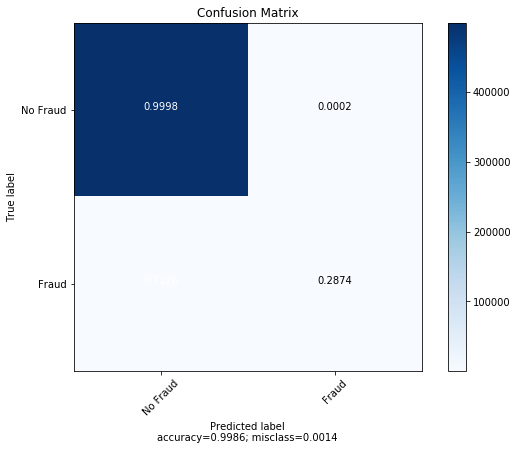

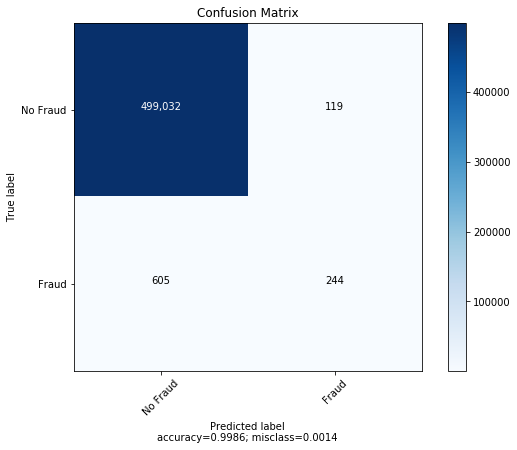

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, y_pred)

plot_confusion_matrix(cm           = cm,
                      normalize    = True,
                      target_names = ['No Fraud', 'Fraud'],
                      title        = "Confusion Matrix")

plot_confusion_matrix(cm           = cm,
                      normalize    = False,
                      target_names = ['No Fraud', 'Fraud'],
                      title        = "Confusion Matrix")


In [52]:
cm_tmp = confusion_matrix(y_valid, y_pred)
df_cm = pd.DataFrame(cm_tmp,
             columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(cm_tmp)
df_cm

[[499032    119]
 [   605    244]]


,pred_neg,pred_pos
neg,499032,119
pos,605,244


In [53]:
roc_auc_score( y_valid, y_pred_proba[:,1])

0.9288185992347396

In [54]:
print("scikit recall " + str(metrics.recall_score(y_valid, y_pred)))
print("scikit precision " + str(metrics.precision_score(y_valid, y_pred)))


scikit recall 0.287396937573616
scikit precision 0.6721763085399449


### create a dictionary of results for comparing different data sets and parameters

In [190]:
results_big_fit_dict = {'roc_auc_score': roc_auc_score( y_valid, y_pred_proba[:,1]), 
                             'classifier': classifier, 'y_pred': y_pred, 'y_pred_proba': y_pred_proba, 'cm': cm,
                            'y_valid': y_valid, 'df_cm': df_cm, 'cleaned_col_list': cleaned_col_list}
add_precision_recall(results_big_fit_dict)

recall my_recall 0.2062937062937063
scikit recall 0.2062937062937063
my precision 0.6020408163265306
scikit precision 0.6020408163265306


### Save the results to disk using pickle


In [105]:
import pickle

In [227]:
folder = "~/mw_portfolio/notebooks-projects-code-notes/dataset/Ad_tracking_fraud_detection/"
filename = "results_first_20mil"
# results_time_breakapart_dict
# results_time_breakapart_grid_best_params_dict


# pickle.dump(classifier, open(f'{folder+filename}', 'wb'))
pickle.dump(classifier, open('dataset/Ad_tracking_fraud_detection/' + filename, 'wb'))

In [ ]:
# some time later...
 
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)

In [228]:
#### or use joblib
from sklearn.externals import joblib
# save the model to disk
filename = 'results_first_20mil.sav'
joblib.dump(classifier, 'dataset/Ad_tracking_fraud_detection/' + filename) 

['dataset/Ad_tracking_fraud_detection/results_first_20mil.sav']

In [213]:
# # some time later...
filename = 'results_big_jobLib.sav'
# # load the model from disk
loaded_model = joblib.load('dataset/Ad_tracking_fraud_detection/' + filename)
%time y_pred = loaded_model.predict(x_valid)
%time y_pred_proba = loaded_model.predict_proba(x_valid)

CPU times: user 12.5 s, sys: 36.3 ms, total: 12.5 s
Wall time: 3.23 s
CPU times: user 12.5 s, sys: 16.5 ms, total: 12.5 s
Wall time: 3.22 s


In [55]:
def my_recall(true_pos, false_neg):
    return (true_pos/(true_pos + false_neg))
def my_precision(true_pos, false_pos):
    return (true_pos/(true_pos + false_pos))

def add_precision_recall(dict_to_update):

    df_cm = dict_to_update['df_cm']
    dict_to_update['recall'] = my_recall(df_cm.pred_pos.pos, df_cm.pred_neg.pos)
    print("recall my_recall " + str(dict_to_update['recall']))
    print("scikit recall " + str(metrics.recall_score(dict_to_update['y_valid'], dict_to_update['y_pred'])))

    dict_to_update['precision'] = my_precision(df_cm.pred_pos.pos, df_cm.pred_pos.neg)
    print("my precision " + str(dict_to_update['precision']))
    print("scikit precision " + str(metrics.precision_score(dict_to_update['y_valid'], dict_to_update['y_pred'])))


In [191]:
print(results_elapsed_time_dict)
print()
print()
print(results_time_breakapart_dict)
print()
print()
print(results_time_breakapart_grid_best_params_dict)
print()
print()
print(results_big_fit_dict)

{'roc_auc_score': 0.9893334268109011, 'classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=23, verbose=0, warm_start=False), 'y_pred': array([0, 0, 0, ..., 0, 0, 0], dtype=int8), 'y_pred_proba': array([[0.99991, 0.00009],
       [0.99999, 0.00001],
       [0.99997, 0.00003],
       ...,
       [0.99996, 0.00004],
       [0.99994, 0.00006],
       [0.99998, 0.00002]]), 'cm': array([[249679,     35],
       [   170,    116]]), 'y_valid': array([0, 0, 0, ..., 0, 0, 0], dtype=int8), 'df_cm':      pred_neg  pred_pos
neg    249679        35
pos       170       116, 'cleaned_col_list': ['ip', 'app', 'device', 'os', 'channel', 'click_timeElapsed'], 'recall': 0.40559440

In [290]:
filename = 'dataset/Ad_tracking_fraud_detection/results_big_fit_dict.pickle'
pickle.dump(results_big_fit_dict, open(filename, 'wb'))

In [37]:
from sklearn.metrics import roc_curve

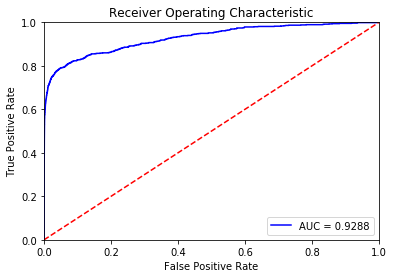

In [55]:

preds = y_pred_proba[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_valid, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Eliminate features with no impact

In [56]:
classifier.feature_importances_

array([0.25961, 0.27427, 0.08154, 0.10179, 0.20943, 0.07335])

In [57]:
feature_imp_df = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), \
                    classifier.feature_importances_), cleaned_col_list), reverse=True))
feature_imp_df.columns= ["percentage of impact", "feature name"]

In [58]:
feature_imp_df

,percentage of impact,feature name
0,0.2743,app
1,0.2596,ip
2,0.2094,channel
3,0.1018,os
4,0.0815,device
5,0.0734,click_timeElapsed


#### Now reduce features and clean up also add in grid search to optimize for roc area. 

In [132]:
from sklearn.model_selection import GridSearchCV


In [80]:
math.log2(len(cleaned_col_list))

3.0

In [95]:
classifier = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [30, 100],
    'max_depth': [3, 5, 15],
    'max_features': [1, .5]
}

param_grid = {
    'max_features': [1, .5, 3],
    'min_samples_leaf' : [3],
    'n_estimators' : [30, 100, 300],
    'min_samples_split': [3, 5, 10, 20],
    'max_depth' : [None, 15]
}
# param_grid = {
#     'max_features': [1, .5, 3],
#     'min_samples_leaf' : [3],
#     'n_estimators' : [30, 100, 300],
# }


scorers = ['precision', 'recall', 'roc_auc' ]
refit_score= 'roc_auc'

In [96]:
time_split = sklearn.model_selection.TimeSeriesSplit(n_splits=2)

In [97]:

grid_search = sklearn.model_selection.GridSearchCV(classifier, param_grid,  refit=refit_score, cv=time_split,
                    return_train_score=True, scoring= scorers)

%time grid_search.fit(x_train[1:], y_train[1:])

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


CPU times: user 4h 48min 32s, sys: 14.5 s, total: 4h 48min 47s
Wall time: 1h 14min 48s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [1, 0.5, 3], 'min_samples_leaf': [3], 'n_estimators': [30, 100, 300], 'min_samples_split': [3, 5, 10, 20], 'max_depth': [None, 15]},
       pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score=True,
       scoring=['precision', 'recall', 'roc_auc'], verbose=0)

In [98]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [99]:
grid_search.cv_results_

{'mean_fit_time': array([ 2.52872,  8.51968, 24.56051,  2.58676,  8.17934, 24.81595,  2.68864,  8.27315, 24.80199,  2.68795,
         8.47093, 24.52386,  6.64743, 21.411  , 64.82156,  6.5453 , 21.15444, 64.25351,  6.54699, 21.05788,
        64.7093 ,  6.59545, 21.55248, 63.9155 ,  5.34523, 16.69453, 50.17905,  5.04338, 16.83992, 49.8784 ,
         5.19225, 16.94299, 50.18186,  5.29212, 16.6365 , 49.94223,  2.38589,  7.92535, 23.35877,  2.28537,
         7.67135, 23.21281,  2.48607,  7.87145, 23.35721,  2.53751,  7.83078, 23.46959,  6.49678, 20.49825,
        62.25199,  6.29535, 20.74771, 61.89111,  6.64658, 20.7505 , 61.7981 ,  6.49474, 20.45159, 62.19888,
         4.89214, 16.19006, 48.83521,  5.09382, 16.09264, 48.33032,  5.04182, 16.44145, 48.26744,  5.04244,
        16.1367 , 48.18459]),
 'std_fit_time': array([ 1.06907,  3.87033, 10.4803 ,  1.01228,  3.41276, 10.73898,  1.11443,  3.52444, 10.84009,  1.11305,
         3.82001, 10.61796,  2.96642,  9.84214, 30.49219,  2.96697,  9.68

In [100]:
grid_search.best_score_

0.9696518600257608

In [101]:
# make the predictions
y_pred = grid_search.predict(x_valid)

print('Best params for {}'.format(refit_score))
print(grid_search.best_params_)

# confusion matrix on the test data.
print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
print(pd.DataFrame(confusion_matrix(y_valid, y_pred),
             columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

Best params for roc_auc
{'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for roc_auc on the test data:
     pred_neg  pred_pos
neg    249692        22
pos       187        99


In [103]:
y_pred_proba = grid_search.predict_proba(x_valid)

In [104]:
roc_auc_score( y_valid, y_pred_proba[:,1])

0.986955342646253

In [102]:
feature_imp_df = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), \
                    grid_search.best_estimator_.feature_importances_), list(x)), reverse=True))
feature_imp_df.columns= ["percentage of impact", "feature name"]

feature_imp_df

,percentage of impact,feature name
0,0.2023,app
1,0.1951,channel
2,0.1709,ip
3,0.1289,os
4,0.1183,click_timeSecond
5,0.0988,device
6,0.0857,click_timeMinute
7,0.0000,click_timeHour
